In [ ]:
%pip install tensorflow-datasets==4.7.0

In [39]:
import datetime
import tensorflow as tf
import tensorflow_datasets as tfds 
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Dense, Conv2D, Reshape, GlobalAveragePooling2D, MaxPooling2D, UpSampling2D

In [125]:
def preprocess(data):
    batch_size = 32
    buffer_size = 2000

    data = (
        data.map(lambda image, target: (tf.cast(image, tf.float32)/256, target))
            .map(lambda image, target: (image, image))
            .map(lambda image, target: (image + tf.random.normal(shape=(28,28,1), mean=0, stddev=0.1), target))
            .map(lambda image, target: (tf.clip_by_value(image, 0, 1), target))
    )
    
    data.cache()
    data = (
        data.shuffle(buffer_size)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)
    )
    return data

In [140]:
def visualize(img, target):
    plt.imshow(img)       
    plt.show()
    plt.imshow(target)       
    plt.show()


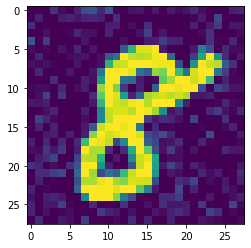

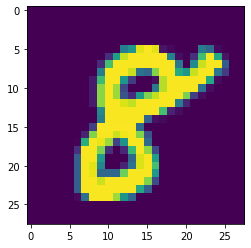

2023-01-07 16:56:21.810367: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [141]:
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)
train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)

for image, target in train_ds.take(1):
    visualize(image[0], target[0])

# Encoder


In [56]:
class Encoder(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(64, 3, activation='relu', padding='same') # 28*28*64
    self.pooling1 = MaxPooling2D(2) # 14*14*64
    self.conv3 = Conv2D(32, 3, activation='relu', padding='same') # 14*14*32
    self.pooling2 = MaxPooling2D(2) # 7*7*32
    self.conv5 = Conv2D(16, 3, activation='relu', padding='same') # 7*7*16
    self.globalpooling = GlobalAveragePooling2D() # 16
    self.out = Dense(10, activation="relu")


  @tf.function
  def __call__(self, x, training=False):
    x = self.conv1(x)
    x = self.pooling1(x)
    x = self.conv3(x)
    x = self.pooling2(x)
    x = self.conv5(x)
    x = self.globalpooling(x)
    x = self.out(x)
    return x

In [60]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = Dense(49, activation="relu")
        self.reshape = Reshape((7, 7, 1))
        self.conv1 = Conv2D(16, 3, activation="relu", padding="same")
        self.upsampling1 = UpSampling2D(2)
        self.conv2 = Conv2D(32, 3, activation="relu", padding="same")
        self.upsampling2 = UpSampling2D(2)
        self.conv_output = Conv2D(1, 3, activation="sigmoid", padding="same")

    @tf.function
    def __call__(self, x, training=False):
        x = self.dense(x)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.upsampling1(x)
        x = self.conv2(x)
        x = self.upsampling2(x)
        x = self.conv_output(x)
        return x

In [47]:
class Autoencoder(tf.keras.Model):
  def __init__(self, optimizer, loss_function):
    super().__init__()
    self.enc = Encoder()
    self.dec = Decoder()

    self.metrics_list = [
      tf.keras.metrics.Mean(name="loss")]

    self.optimizer = optimizer
    self.loss_function = loss_function

  @property
  def metrics(self):
    return self.metrics_list
    
  def reset_metrics(self):
     for metric in self.metrics:
        metric.reset_state()

  def call(self, input, training=False):
    embedding = self.enc(input)
    output = self.dec(embedding)
    return output

  @tf.function
  def train_step(self, data):
    image, target = data
    with tf.GradientTape() as tape: 
      prediction = self(image, training = True)
      loss = self.loss_function(target, prediction)

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
    self.metrics[0].update_state(loss)  
    return gradients

  @tf.function
  def test_step(self, data):
    image, target = data
    prediction = self(image, training = False)
    loss = self.loss_function(target, prediction)
    self.metrics[0].update_state(loss)
    return prediction, target

    

In [142]:
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range(epochs):
        model.reset_metrics()

        for data in tqdm(train_ds, position=0, leave=True):
            model.train_step(data)

        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
        
        print("Epoch: ", epoch+1)
        print("Loss: ", model.metrics[0].result().numpy(), "(Train)")
        model.reset_metrics()

        for data in tqdm(test_ds, position=0, leave=True):
            prediction, target = model.test_step(data)

        visualize(prediction[0], target[0])

        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)

        print("Loss: ", model.metrics[0].result().numpy(), "(Test)")

100%|██████████| 1875/1875 [00:20<00:00, 91.37it/s] 


Epoch:  1
Loss:  0.061607696 (Train)


100%|██████████| 313/313 [00:02<00:00, 117.44it/s]


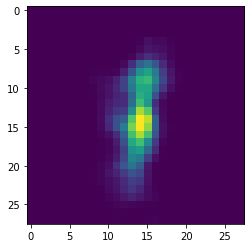

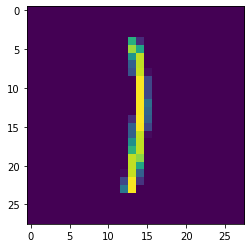

Loss:  0.04888445 (Test)


100%|██████████| 1875/1875 [00:20<00:00, 91.58it/s] 


Epoch:  2
Loss:  0.04361986 (Train)


100%|██████████| 313/313 [00:02<00:00, 147.70it/s]


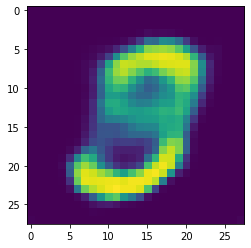

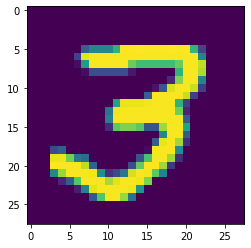

Loss:  0.040641677 (Test)


100%|██████████| 1875/1875 [00:12<00:00, 149.84it/s]


Epoch:  3
Loss:  0.039972108 (Train)


100%|██████████| 313/313 [00:01<00:00, 157.26it/s]


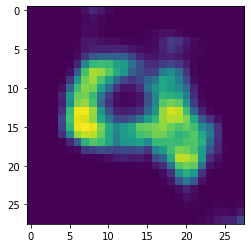

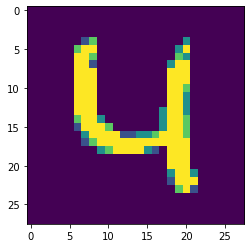

Loss:  0.038646992 (Test)


100%|██████████| 1875/1875 [00:12<00:00, 148.23it/s]


Epoch:  4
Loss:  0.038418114 (Train)


100%|██████████| 313/313 [00:02<00:00, 122.82it/s]


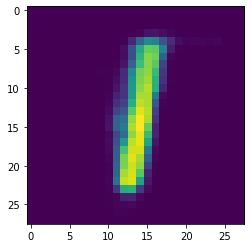

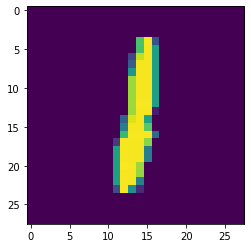

Loss:  0.03811849 (Test)


100%|██████████| 1875/1875 [00:11<00:00, 161.69it/s]


Epoch:  5
Loss:  0.037361763 (Train)


100%|██████████| 313/313 [00:02<00:00, 122.80it/s]


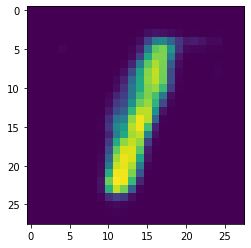

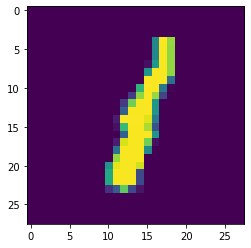

Loss:  0.0372425 (Test)


100%|██████████| 1875/1875 [00:12<00:00, 151.39it/s]


Epoch:  6
Loss:  0.036624588 (Train)


100%|██████████| 313/313 [00:01<00:00, 161.98it/s]


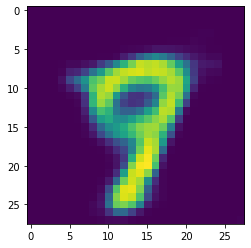

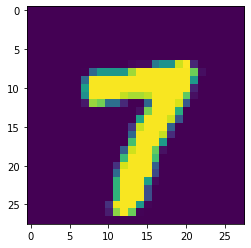

Loss:  0.035915073 (Test)


100%|██████████| 1875/1875 [00:11<00:00, 158.97it/s]


Epoch:  7
Loss:  0.03604206 (Train)


100%|██████████| 313/313 [00:01<00:00, 163.26it/s]


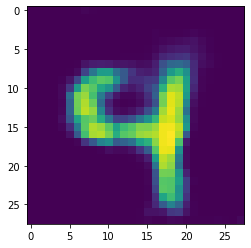

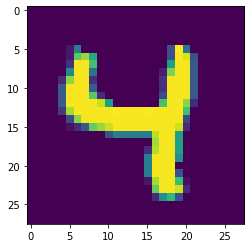

Loss:  0.035372306 (Test)


100%|██████████| 1875/1875 [00:12<00:00, 144.49it/s]


Epoch:  8
Loss:  0.035561483 (Train)


100%|██████████| 313/313 [00:01<00:00, 166.34it/s]


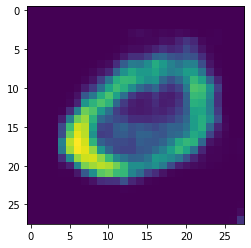

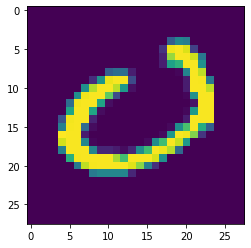

Loss:  0.035297804 (Test)


100%|██████████| 1875/1875 [00:12<00:00, 154.78it/s]


Epoch:  9
Loss:  0.035216916 (Train)


100%|██████████| 313/313 [00:01<00:00, 158.21it/s]


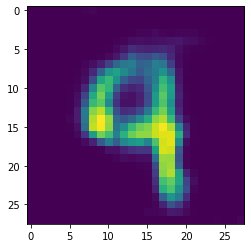

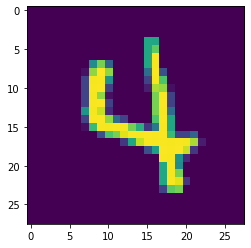

Loss:  0.034601938 (Test)


100%|██████████| 1875/1875 [00:12<00:00, 151.20it/s]


Epoch:  10
Loss:  0.034897763 (Train)


100%|██████████| 313/313 [00:02<00:00, 148.05it/s]


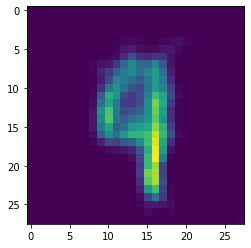

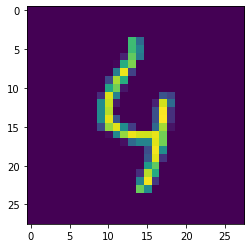

Loss:  0.034683455 (Test)


In [143]:
batch_size = 32
epochs = 10
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.MeanSquaredError()

autoencoder = Autoencoder(optimizer=optimizer, loss_function=loss_function)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/{current_time}/train"
test_log_path = f"logs/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(autoencoder, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)